In [1]:
import tensorflow as tf
import datetime
import os
from src.utils import *
from src.defineModels import *
from tensorflow.keras import optimizers
from src.utils import *
import easygui


# Set data paths
## Start by locating the .mat files that have all the natural scene data in the repo


In [2]:
# define the input path
# data set location
data_set_folder = '/Users/barabadwan/PycharmProjects/CNNModelofT4T5'
# save in a folder with the date
date_str = str(datetime.datetime.now())
date_str = '_'.join(date_str.split(' '))
date_str = '-'.join(date_str.split(':'))

# The three datasets based on whether they are of natural scene, sinewaves, or synthetic
data_set_names = ['xtPlot_ns20_xe360_xs360_ye100_ys5_pe360_ps5_sf100_tt1_nt16_hl0-2_vs100_df0-05_no0_csInf_sy0.mat',
                  'xtPlot_sineWaves_sl20_ll90_pe360_ps5_sf100_tt1_nt6080_hl0-2_vs100_df0-05_no0_csInf.mat',
                  'xtPlot_ns20_xe360_xs360_ye100_ys5_pe360_ps5_sf100_tt1_nt16_hl0-2_vs100_df0-05_no0_csInf_sy1.mat']

# Here I am only selecting the first of the three
image_type_idxes = [0]
image_types = ['nat', 'sine', 'synth']

#Write the path for each
for image_type_idx in image_type_idxes:
    path = data_set_folder + '/Data/natural_images/xt/' + data_set_names[image_type_idx]

# Set parameters

In [3]:
num_runs = 1
filter_time = 0.3  # s
noise_std_list = [0.1]
filter_space = 15  # degrees
sum_over_space = [False]
num_filt = 4
binarize = True
epochs = 50
batch_size = 128
learningRate = 0.05
learningDecay = 0

if binarize:
    binaryName = 'Binary'
else:
    binaryName = 'Velocity'

# Load data

In [4]:
train_in, train_out, dev_in, dev_out, test_in, test_out, sample_freq, phase_step = load_data_rr(path, binarize=binarize)

# Set up filter lengths based on the entered filter time and space and the associated phase/freq
filter_indicies_t = int(np.ceil(filter_time*int(sample_freq)))
filter_indicies_x = int(np.ceil(filter_space/int(phase_step)))

m, size_t, size_x, n_c = train_in.shape




# process the data based on the model of interest

In [5]:

def processData(model):
    #Load data
    train_in, train_out, dev_in, dev_out, test_in, test_out, sample_freq, phase_step = load_data_rr(path,
                                                                                                    binarize=binarize)
    # We must process the data in two ways, for models where we don't average space we need to tile the velocity
    # over the spatial dimension 
    pad_t = int((filter_indicies_t- 1))
    pad_x = int((filter_indicies_x- 1))
    if model.name not in ['LNPool_model' , "lnPool_model_Opp" , "conductance_pool_model_opp", "conductance_pool_model", 'SLN_model']:
        train_out = np.tile(train_out, (1, 1, size_x - pad_x, 1))
        dev_out = np.tile(dev_out, (1, 1, size_x - pad_x, 1))
        test_out = np.tile(test_out, (1, 1, size_x - pad_x, 1))

    if model.name in ['SLN_model']:
        train_out = np.tile(train_out, (1, 1, size_x - 2*pad_x, 1))
        dev_out = np.tile(dev_out, (1, 1, size_x - 2*pad_x, 1))
        test_out = np.tile(test_out, (1, 1, size_x - 2*pad_x, 1))

        
    # We need to remove the first chunk of the time as we cant make predictions in the first segment as it needs
    # to be longer than our 
    train_out = train_out[:, pad_t:, :, :]
    dev_out = dev_out[:, pad_t:, :, :]
    test_out = test_out[:, pad_t:, :, :]

    return train_out, dev_out, test_out



# Define models


In [6]:
LNModel_Opp = ln_model_Opp(input_shape=(size_t, size_x, n_c),
                     filter_shape=[filter_indicies_t, filter_indicies_x],
                     num_filter=num_filt, binarize=binarize)

conductanceModel = conductance_model(input_shape=(size_t, size_x, n_c),
                     filter_shape=[filter_indicies_t, filter_indicies_x],
                     num_filter=num_filt,
                     sum_over_space=sum_over_space,
                     binarize = binarize) # worth pointing out, the spatial filter size is reset in the model

LNLNModel = lnln_model(input_shape=(size_t, size_x, n_c),
                     filter_shape=[filter_indicies_t, filter_indicies_x],
                     num_filter=num_filt,
                     sum_over_space=sum_over_space,
                     binarize = binarize)

sLN = Sln_model(input_shape=(size_t, size_x, n_c),
                     filter_shape=[filter_indicies_t, filter_indicies_x],
                     num_filter=num_filt, binarize=binarize)

# Fit Models

In [9]:
def fitModel(model,retrain=0, trainMore=0):
    optimizer = optimizers.Adam(lr=learningRate, decay=learningDecay)
    if retrain:
        train_out, dev_out, test_out = processData(model)
        save_folder = data_set_folder+'/'+model.name + '/' + binaryName + '/' +date_str + '/'
        os.makedirs(save_folder)
        saveCallbackFolder, saveCallback = makeSaveCallback(save_folder)
        if binarize:
            model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        else:
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[r2])

        hist = model.fit(train_in, (train_out), verbose=2, epochs=epochs, batch_size=batch_size,
                         validation_data=(dev_in, (dev_out)), callbacks=[saveCallback])
        model.save(save_folder+'savedmodel.h5')
        if binarize:
            plotAccuracyLoss(hist, save_folder)
        else:
            plotRsqLoss(hist, save_folder)



    else:
        path = easygui.fileopenbox(default = os.getcwd(), filetypes = ['*.h5'])
        # save_folder = os.path.dirname(path)
        save_folder_orig =  os.path.split(os.path.dirname(path))[1]
        model = tf.keras.models.load_model(path, custom_objects={"BiasLayer":BiasLayer}, compile=False)
        save_folder = data_set_folder + '/' + model.name + '/' + binaryName + '/'+ date_str + '_Retraining_' + save_folder_orig + '/'
        os.makedirs(save_folder)
        hist = model

        if trainMore:
            train_out, dev_out, test_out = processData(model)
            model.set_weights(model.get_weights(save_folder_orig))
            saveCallbackFolder, saveCallback = makeSaveCallback(save_folder)
            if binarize:
                model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
            else:
                model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[r2])
            model.load_weights(save_folder_orig)
            hist = model.fit(train_in, (train_out), verbose=2, epochs=epochs, batch_size=batch_size,
                             validation_data=(dev_in, (dev_out)), callbacks=[saveCallback])
            if binarize:
                plotAccuracyLoss(hist, save_folder)
            else:
                plotRsqLoss(hist, save_folder)




    getPlotLayerWeights(model, save_folder)
    return


# Plot Results

/Users/barabadwan/PycharmProjects/CNNModelofT4T5/src/utils.py:109: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)


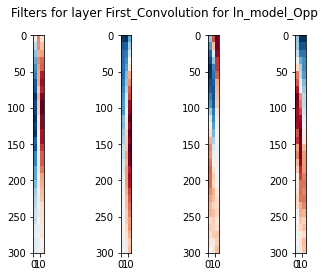

In [14]:


# fitModel(conductanceModel,1,0)
fitModel(LNModel_Opp,0,0)
# fitModel(LNLNModel,0,0)
# fitModel(sLN, 0,0)


# Not being used anymore

# fitModel(LNModel,1,1)
# fitModel(LNPoolModel, 1)

# fitModel(LNLNModel,0,1)


# fitModel(conductancePoolOppModel,1,0)

# fitModel(conductanceOppModel,1,0)

# fitModel(conductancePoolModel,0,1)

# fitModel(anatomicalModel)
# PlotLearningRateSch(hist)

# fitModel(LNPool_Model_Opp,1,1)

plt.show()
